In [4]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

In [5]:
# load dataset
with open('input/2019fiveVfive.pkl', 'rb') as f:
    game_data = pickle.load(f)

In [6]:
# Initialise the league dictionary
league_data = {}
league_data['Shot'] = {}
league_data['Shot']['x'] = []
league_data['Shot']['y'] = []
league_data['Goal'] = {}
league_data['Goal']['x'] = []
league_data['Goal']['y'] = []

In [7]:
# Initialise the player dictionary
player_data = {}
player_data['Shot'] = {}
player_data['Shot']['x'] = []
player_data['Shot']['y'] = []
player_data['Goal'] = {}
player_data['Goal']['x'] = []
player_data['Goal']['y'] = []

In [8]:
# Select line to visualize
# line = {'Sebastian Aho', 'Teuvo Teravainen', 'Andrei Svechnikov'}       #CAR_F1
# line = {'Nikita Kucherov', 'Brayden Point','Ondrej Palat'}              #TBL_F1
# line = {'Dominik Kubalik', 'Jonathan Toews','Brandon Saad'}             #CHI_F1
line = {'Alex DeBrincat', 'Kirby Dach','Patrick Kane'}                  #CHI_F2
# line = {'Alex Nylander', 'Dylan Strome','Andrew Shaw'}                  #CHI_F3
# line = {'Drake Caggiula', 'David Kampf','Ryan Carpenter'}                #CHI_F4

In [9]:
# First loop over the elements of game_data. Each one of these is an NHL game and contains all of the game event data.
event_types = ['Shot','Goal']

for play in game_data: # For each play
    if 'players' in play:
        for player in play['players']:
            if player['player']['fullName'] in line and player['playerType'] in ["Shooter","Scorer"]: 
                for event in event_types:  # For each event (Shot,Goal)
                    # If the play contains one of the events
                    if play['result']['event'] in [event]:  
                        # If the event contains coordinates
                        if 'x' in play['coordinates']:
                            # Save the coordinates to the growing list
                            player_data[event]['x'].append(play['coordinates']['x'])
                            player_data[event]['y'].append(play['coordinates']['y'])
for play in game_data: # For each play
    for event in event_types:  # For each event (Shot,Goal)
        # If the play contains one of the events
        if play['result']['event'] in [event]:  
            # If the event contains coordinates
            if 'x' in play['coordinates']:
                # Save the coordinates to the growing list
                league_data[event]['x'].append(play['coordinates']['x'])
                league_data[event]['y'].append(play['coordinates']['y'])

In [10]:
# Get the total number of shots made by the player
player_total_shots = len(player_data['Shot']['x']) + len(player_data['Goal']['x'])
# Find the players goal score percentage
player_goal_pct = len(player_data['Goal']['x'])/player_total_shots
# Find the total number of shots taken in the league
league_total_shots = len(league_data['Shot']['x']) + len(league_data['Goal']['x'])
# Get the league percentage
league_goal_pct = len(league_data['Goal']['x'])/league_total_shots
# Calculate the spread of the SOG (Shots on Goal) %
PL_e_spread = player_goal_pct-league_goal_pct

# print(player_total_shots)
# print(player_goal_pct)
# print(league_total_shots)
# print(league_goal_pct)
# print(PL_e_spread)

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


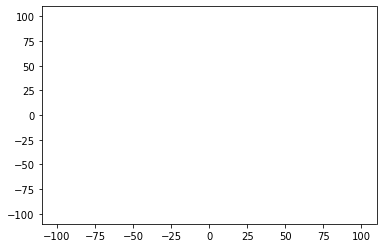

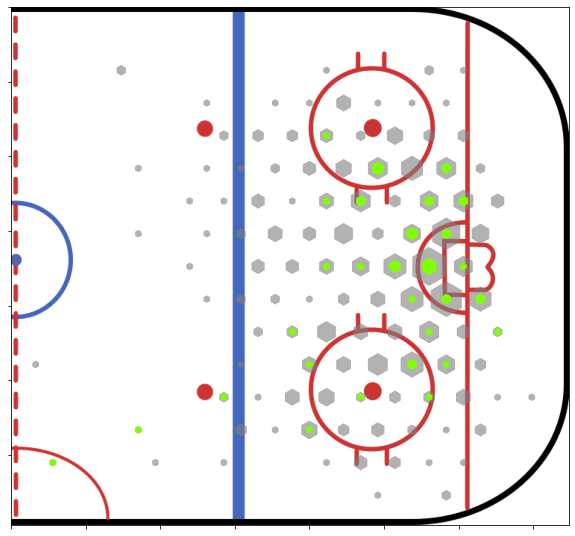

In [11]:
'''
Create a heat map
'''

# To keep the aspect ration correct we use a square figure size
xbnds = np.array([-100.,100.0])
ybnds = np.array([-100,100])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
# We are going to bin in 30 unit increments.  It is fun to play with this!  
gridsize= 30;mincnt=0

# First concatenate the arrays for x and y league data
player_x_all_shots = player_data['Shot']['x'] + player_data['Goal']['x']
player_y_all_shots = player_data['Shot']['y'] + player_data['Goal']['y']
# Perform the coordinate flipping!
player_x_all_shots_normalized = []
player_y_all_shots_normalized = []
# Enumerate the list so we can use the index for y also
for i,s in enumerate(player_x_all_shots):
    if player_x_all_shots[i] <0:
        player_x_all_shots_normalized.append(-player_x_all_shots[i])
        player_y_all_shots_normalized.append(-player_y_all_shots[i])
    else:
        player_x_all_shots_normalized.append(player_x_all_shots[i])
        player_y_all_shots_normalized.append(player_y_all_shots[i])
        
# Do the same treatment for the goals
player_x_goal_normalized = []
player_y_goal_normalized=[]
for i,s in enumerate(player_data['Goal']['x']):
    if player_data['Goal']['x'][i] <0:
       player_x_goal_normalized.append(-player_data['Goal']['x'][i])
       player_y_goal_normalized.append(-player_data['Goal']['y'][i])
    else:
       player_x_goal_normalized.append(player_data['Goal']['x'][i])
       player_y_goal_normalized.append(player_data['Goal']['y'][i])

# First we will used the hexbin function to simply bucket our shot data into basically a 2D histogram
player_hex_data = plt.hexbin(player_x_all_shots_normalized,
   player_y_all_shots_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0)
# Now we extract the bin coordinates and counts
player_verts = player_hex_data.get_offsets()
player_shot_frequency = player_hex_data.get_array()
# Do the same thing for the goal data
player_goal_hex_data =  plt.hexbin(player_x_goal_normalized,
   player_y_goal_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0)
# Since the grid is the same we can use a shared bin coordinate set from the above. So here we just get the counts
player_goal_frequency = player_goal_hex_data.get_array()

# Using matplotlib we create a new figure for plotting
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Clean up the figure to be completely blank
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
# Remove the labelling of axes
ax.set_xticklabels(labels = [''], fontsize = 18, alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18, alpha = .7,minor=False)
# Using pillow to get the rink image and extract the image size
I = Image.open('input/nhl-images/half.png')
ax.imshow(I);width, height = I.size

# Calculate the scaling factor and offset (trial and error)
scalingx=width/100-0.6
scalingy=height/100+0.5
x_trans=33
y_trans=height/2
# We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
S = 3.8*scalingx

# Loop over the locations and draw the hex for shots
for i,v in enumerate(player_verts):
    # Ignore empty locations
    if player_shot_frequency[i] < 1:
        continue
    # Normalize the shot frequency data between 0-1 
    scaled_player_shot_frequency = player_shot_frequency[i]/max(player_shot_frequency)
    # Scale the hexagon size based on shot frequency
    radius = S*math.sqrt(scaled_player_shot_frequency)
    # Finally we will plot the hexagon including the scaling and translations we found earlier
    hex = RegularPolygon((x_trans+v[0]*scalingx, 
      y_trans-v[1]*scalingy),numVertices=6, radius=radius,
      orientation=np.radians(0),alpha=0.6, edgecolor=None, facecolor='grey')
    ax.add_patch(hex)
    fig.savefig('line.png', dpi=100)

# Loop over the locations and draw the hex for goals
for i,v in enumerate(player_verts):
    # Ignore empty locations
    if player_goal_frequency[i] < 1:
        continue
    # Normalize the shot frequency data between 0-1 
    scaled_player_goal_frequency = player_goal_frequency[i]/max(player_shot_frequency)
    # Scale the hexagon size based on shot frequency
    radius = S*math.sqrt(scaled_player_goal_frequency)
    # Finally we will plot the hexagon including the scaling and translations we found earlier
    hex = RegularPolygon((x_trans+v[0]*scalingx, 
      y_trans-v[1]*scalingy),numVertices=6, radius=radius,
      orientation=np.radians(0),alpha=1, edgecolor=None, facecolor='chartreuse')
    ax.add_patch(hex)
    fig.savefig('output/line_CHI_F2.png', dpi=100)